## 使用keras训练模型

In [4]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.keras.backend.clear_session()
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## 一般的模型构造、训练、测试流程

In [5]:
#模型构造
inputs = keras.Input(shape=(784,),name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

#载入数据
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0

x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

#训练模型
history = model.fit(x_train, y_train, batch_size=64, epochs=10,
                   validation_data=(x_val, y_val))

print('history:')
print(history.history)

result = model.evaluate(x_test, y_test, batch_size=128)
print('evaluate:')
print(result)

pred = model.predict(x_test[:2])
print('predict:')
print(pred)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s 44us/sample - loss: 0.3458 - sparse_categorical_accuracy: 0.9016 - val_loss: 0.1910 - val_sparse_categorical_accuracy: 0.9451
Epoch 2/10
50000/50000 [==============================] - 2s 36us/sample - loss: 0.1617 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.1570 - val_sparse_categorical_accuracy: 0.9529
Epoch 3/10
50000/50000 [==============================] - 2s 36us/sample - loss: 0.1173 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.1110 - val_sparse_categorical_accuracy: 0.9687
Epoch 4/10
50000/50000 [==============================] - 2s 37us/sample - loss: 0.0941 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.1169 - val_sparse_categorical_accuracy: 0.9656
Epoch 5/10
50000/50000 [==============================] - 2s 36us/sample - loss: 0.0787 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.0994 - val_sparse_categorical_accuracy: 0.9718
Epoch 6/10
5000

## 自定义损失函数和指标
自定义指标只需要继承Metric类，然后重写函数__init__(self)，初始化。

update_state(self,y_ture,y_pred,sample_weight=None),使用目标y_ture和模型y_pred来更新状态变量。

result(self),使用状态变量来计算最终结果。

reset_states(self),重新初始化度量的状态。

In [6]:
class CatgoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name='binary_true_positives', **kwargs):
        super(CatgoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
    
    def update_state(self,y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred)
        y_true = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
        
        y_true = tf.cast(y_true, tf.float32)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            y_true = tf.multiply(sample_weight, y_true)
            
        return self.true_positives.assign_add(tf.reduce_sum(y_true))
    
    def result(self):
        return tf.identity(self.true_positives)
    
    def reset_states(self):
        self.true_positives.assign(0.)
        
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[CatgoricalTruePositives()])

model.fit(x_train, y_train,
         batch_size=64, epochs=3)
        

Epoch 1/3
50000/50000 [==============================] - 2s 33us/sample - loss: 0.0363 - binary_true_positives: 11775.0000
Epoch 2/3
50000/50000 [==============================] - 2s 32us/sample - loss: 0.0331 - binary_true_positives: 12881.0000
Epoch 3/3
50000/50000 [==============================] - 2s 31us/sample - loss: 0.0285 - binary_true_positives: 13265.0000


In [7]:
#以定义网络层的方式添加网络loss
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) *0.1)
        return inputs
    
inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = ActivityRegularizationLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.fit(x_train,y_train, batch_size=32, epochs=1)

50000/50000 [==============================] - 3s 68us/sample - loss: 2.3489 - sparse_categorical_accuracy: 0.1132


In [8]:
#也可以自定义网络层的方式添加要统计的metrics
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        self.add_metric(keras.backend.std(inputs),
                        name='std_of_activation',
                        aggregation='mean')
        return inputs
    
inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = MetricLoggingLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

50000/50000 [==============================] - 4s 71us/sample - loss: 0.3103 - sparse_categorical_accuracy: 0.9096 - std_of_activation: 1.0379


处理使用validation_data传入测试数据，还可以使用validation_split划分验证数据

ps:validation_split只能在用numpy数据训练的情况下使用

In [9]:
model.fit(x_train, y_train, batch_size=32, epochs=1, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 4s 88us/sample - loss: 0.1459 - sparse_categorical_accuracy: 0.9571 - std_of_activation: 1.0915 - val_loss: 0.1546 - val_sparse_categorical_accuracy: 0.9525 - val_std_of_activation: 1.0968


## 使用tf.data构造数据

In [10]:
def get_compiled_model():
    inputs = keras.Input(shape=(784,), name='mnist_input')
    h1 = layers.Dense(64, activation='relu')(inputs)
    h2 = layers.Dense(64, activation='relu')(h1)
    outputs = layers.Dense(10, activation='softmax')(h2)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(),
                 loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model
model = get_compiled_model()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

# model.fit(train_dataset, epochs=3)
# steps_per_epoch 每个epoch只训练几步
# validation_steps 每次验证，验证几步
model.fit(train_dataset, epochs=3, steps_per_epoch=100,
         validation_data=val_dataset, validation_steps=3)

Epoch 1/3
100/100 [==============================] - 1s 10ms/step - loss: 0.8311 - sparse_categorical_accuracy: 0.7791 - val_loss: 0.4126 - val_sparse_categorical_accuracy: 0.8750
Epoch 2/3
100/100 [==============================] - 0s 4ms/step - loss: 0.3828 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.3594 - val_sparse_categorical_accuracy: 0.8698
Epoch 3/3
100/100 [==============================] - 0s 4ms/step - loss: 0.3295 - sparse_categorical_accuracy: 0.9030 - val_loss: 0.2310 - val_sparse_categorical_accuracy: 0.9323


## 4.样本权重和类权重
“样本权重”数组是一个数字数组，用于指定批处理中每个样本在计算总损失时应具有多少权重。 它通常用于不平衡的分类问题（这个想法是为了给予很少见的类更多的权重）。 当使用的权重是1和0时，该数组可以用作损失函数的掩码（完全丢弃某些样本对总损失的贡献）。

“类权重”dict是同一概念的更具体的实例：它将类索引映射到应该用于属于该类的样本的样本权重。 例如，如果类“0”比数据中的类“1”的一半，则可以使用class_weight = {0：1.，1：0.5}。

In [11]:
# 增加第5类的权重
import numpy as np
# 类权重
model = get_compiled_model()
class_weight = {i:1.0 for i in range(10)}
class_weight[5] = 2.0
print(class_weight)
model.fit(x_train, y_train,
         class_weight=class_weight,
         batch_size=64,
         epochs=4)
# 样本权重
model = get_compiled_model()
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0
model.fit(x_train, y_train,
         sample_weight=sample_weight,
         batch_size=64,
         epochs=4)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}
Epoch 1/4
50000/50000 [==============================] - 2s 39us/sample - loss: 0.3786 - sparse_categorical_accuracy: 0.9000
Epoch 2/4
50000/50000 [==============================] - 2s 34us/sample - loss: 0.1749 - sparse_categorical_accuracy: 0.9525
Epoch 3/4
50000/50000 [==============================] - 2s 35us/sample - loss: 0.1251 - sparse_categorical_accuracy: 0.9649
Epoch 4/4
50000/50000 [==============================] - 2s 35us/sample - loss: 0.0998 - sparse_categorical_accuracy: 0.9719
Epoch 1/4
50000/50000 [==============================] - 2s 38us/sample - loss: 0.3666 - sparse_categorical_accuracy: 0.9039
Epoch 2/4
50000/50000 [==============================] - 2s 34us/sample - loss: 0.1701 - sparse_categorical_accuracy: 0.9531
Epoch 3/4
50000/50000 [==============================] - 2s 34us/sample - loss: 0.1235 - sparse_categorical_accuracy: 0.9656
Epoch 4/4
50000/50000 [=====================

In [12]:
# tf.data数据
model = get_compiled_model()

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train,
                                                    sample_weight))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3, )

Epoch 1/3
782/782 [==============================] - 3s 4ms/step - loss: 0.3801 - sparse_categorical_accuracy: 0.8996
Epoch 2/3
782/782 [==============================] - 3s 3ms/step - loss: 0.1832 - sparse_categorical_accuracy: 0.9496
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 0.1319 - sparse_categorical_accuracy: 0.9635


## 多输入多输出模型

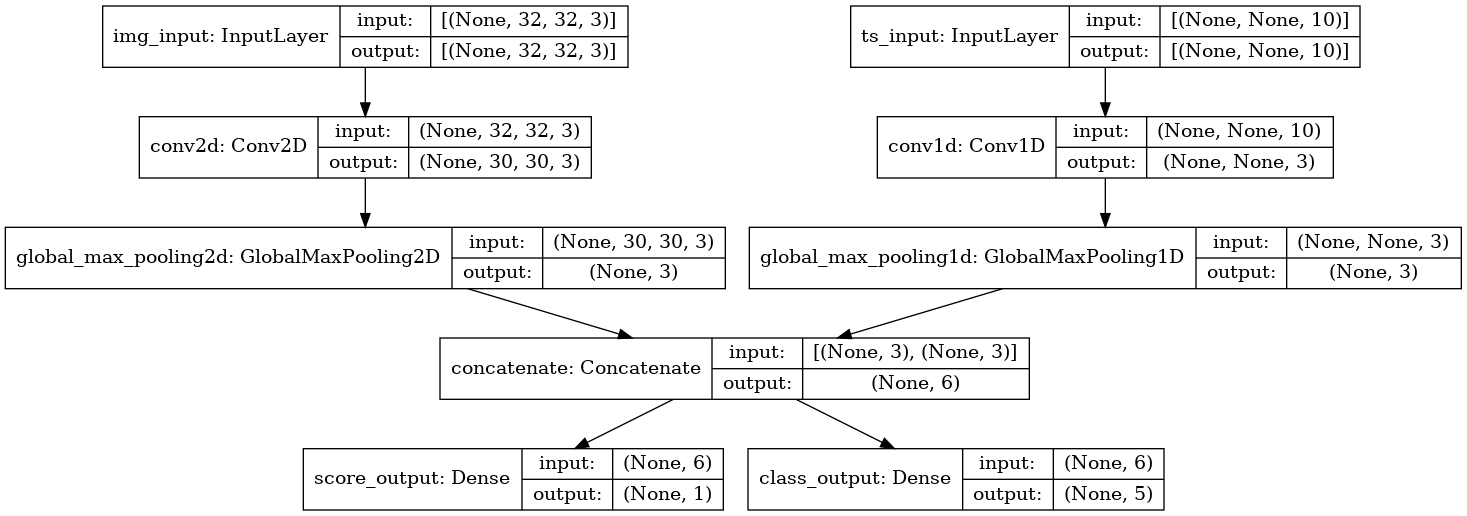

In [13]:
image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, activation='softmax', name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])
keras.utils.plot_model(model, 'multi_input_output_model.png'
                       , show_shapes=True)

In [17]:
# 可以为模型指定不同的loss和metrics
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()]
)

# 还可以制定loss的权重
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output':keras.losses.MeanSquaredError(),
          'class_output':keras.losses.CategoricalCrossentropy()},
    metrics={'score_output':[keras.metrics.MeanAbsolutePercentageError(),
                             keras.metrics.MeanAbsoluteError()],
             'class_output':[keras.metrics.CategoricalAccuracy()]
            },
    loss_weight={'score_output':2.,
                 'class_output':1.}
)

#可以把不需要传播的loss置0
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()]
)

#或者使用字典方式的loss
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'class_output':keras.losses.CategoricalCrossentropy()})

W0607 15:38:00.300908 140199823247168 training_utils.py:1152] Output score_output missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to score_output.


## 使用回调（callback）
keras中的回调实在训练期间（epoch开始时，batch结束时，epoch结束时等）在不同点调用对象，可以实现以下的行为：
 - 在训练期间的不同时间点进行验证（超出内置的每个时期验证）
 - 定期检查模型或超过某个精度阈值
 - 在训练似乎平稳时改变模型的学习率
 - 在训练似乎平稳时对顶层进行微调
 - 在训练结束或者超过某个性能阈值时发送带女子邮件或者即时消息通知等等
 
**可使用的内置回调有**
 - Modelcheckpoint：定期保存模型
 - EarlyStopping：当训练不再改进验证指标时候停止训练
 - TensorBoard：定期编写可在TensorBoard中现实的模型日志（更多细节可见“可视化”）
 - CSVLogger：将就是和指标数据流失传输到CSV文件
 - 等等

### 回调使用

In [19]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=2,
        verbose=1)
]

model.fit(x_train, y_train,
         epochs=20,
         batch_size=64,
         callbacks=callbacks,
         validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 2s 43us/sample - loss: 0.3685 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.2361 - val_sparse_categorical_accuracy: 0.9264
Epoch 2/20
40000/40000 [==============================] - 1s 37us/sample - loss: 0.1719 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.1773 - val_sparse_categorical_accuracy: 0.9457
Epoch 3/20
40000/40000 [==============================] - 2s 39us/sample - loss: 0.1275 - sparse_categorical_accuracy: 0.9624 - val_loss: 0.1568 - val_sparse_categorical_accuracy: 0.9528
Epoch 4/20
40000/40000 [==============================] - 2s 39us/sample - loss: 0.1024 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.1502 - val_sparse_categorical_accuracy: 0.9548
Epoch 5/20
40000/40000 [==============================] - 2s 38us/sample - loss: 0.0836 - sparse_categorical_accuracy: 0.9749 - val_loss: 0.1540 - val_sparse_categorical_accuracy: 0.9563
Epoch 00005: ea

In [20]:
#checkpoint模型回调
model = get_compiled_model()

check_callback = keras.callbacks.ModelCheckpoint(
    filepath='mymodel_{epoch}.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=[check_callback],
          validation_split=0.2
         )

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
38592/40000 [===========================>..] - ETA: 0s - loss: 0.3653 - sparse_categorical_accuracy: 0.8972
Epoch 00001: val_loss improved from inf to 0.21653, saving model to mymodel_1.h5
40000/40000 [==============================] - 2s 44us/sample - loss: 0.3609 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.2165 - val_sparse_categorical_accuracy: 0.9357
Epoch 2/3
39744/40000 [============================>.] - ETA: 0s - loss: 0.1702 - sparse_categorical_accuracy: 0.9497
Epoch 00002: val_loss improved from 0.21653 to 0.17381, saving model to mymodel_2.h5
40000/40000 [==============================] - 1s 37us/sample - loss: 0.1700 - sparse_categorical_accuracy: 0.9498 - val_loss: 0.1738 - val_sparse_categorical_accuracy: 0.9489
Epoch 3/3
39552/40000 [============================>.] - ETA: 0s - loss: 0.1245 - sparse_categorical_accuracy: 0.9630
Epoch 00003: val_loss improved from 0.17381 to 0.15544, saving model to mymode

In [21]:
#动态调整学习率
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [23]:
#使用tensorboard
tensorboard_cbk = keras.callbacks.TensorBoard(
    log_dir='./full_pathto_your_logs')
model.fit(x_train,y_train,
          epochs=5,
          batch_size=64,
          callbacks=[tensorboard_cbk],
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 2s 43us/sample - loss: 0.1010 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.1544 - val_sparse_categorical_accuracy: 0.9551
Epoch 2/5
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0837 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.1393 - val_sparse_categorical_accuracy: 0.9609
Epoch 3/5
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0709 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.1464 - val_sparse_categorical_accuracy: 0.9598
Epoch 4/5
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0607 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.1452 - val_sparse_categorical_accuracy: 0.9613
Epoch 5/5
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0525 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.1393 - val_sparse_categorical_accuracy: 0.9641


### 创建自己的回调方法

In [24]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.losses=[]
    def on_epoch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))
        print('\nloss:', self.losses[-1])

model = get_compiled_model()

callbacks = [
    LossHistory()
]

model.fit(x_train,y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
38656/40000 [===========================>..] - ETA: 0s - loss: 0.3657 - sparse_categorical_accuracy: 0.8973
loss: 0.3613256821870804
40000/40000 [==============================] - 2s 47us/sample - loss: 0.3613 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.2241 - val_sparse_categorical_accuracy: 0.9304
Epoch 2/3
39744/40000 [============================>.] - ETA: 0s - loss: 0.1689 - sparse_categorical_accuracy: 0.9507
loss: 0.16862511169016361
40000/40000 [==============================] - 2s 39us/sample - loss: 0.1686 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.1783 - val_sparse_categorical_accuracy: 0.9452
Epoch 3/3
39552/40000 [============================>.] - ETA: 0s - loss: 0.1245 - sparse_categorical_accuracy: 0.9635
loss: 0.1243461835294962
40000/40000 [==============================] - 1s 34us/sample - loss: 0.1243 - sparse_categorical_accuracy: 0.9635 - val_loss: 0.1494 - val_sparse_categorical_accuracy:

## 自己构造训练和验证循环

In [25]:
#get the model
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

#初始化optimizer
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
#初始化loss
loss_fn = keras.losses.SparseCategoricalCrossentropy()

#准备训练数据
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

#构造循环
for epoch in range(3):
    print('epoch: ',epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        #开一个gradient tape，计算梯度
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        if step%200 == 0:
            print('Training loss (for one batch) at step %s: %s'%
                  (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step+1)*64))

epoch:  0
Training loss (for one batch) at step 0: 2.311230182647705
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2681937217712402
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.179314136505127
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.116332530975342
Seen so far: 38464 samples
epoch:  1
Training loss (for one batch) at step 0: 2.0092639923095703
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.9650688171386719
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.884655475616455
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.7521264553070068
Seen so far: 38464 samples
epoch:  2
Training loss (for one batch) at step 0: 1.6472610235214233
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.6006805896759033
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.5293551683425903
Seen so far: 25664 samples
Training l

In [28]:
# 训练并验证
# Get model
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

#初始化optimizer
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
#初始化loss
loss_fn = keras.losses.SparseCategoricalCrossentropy()

#准备metrics
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

#准备数据集
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

#准备验证集
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

for epoch in range(3):
    print('Start of epoch %d' % (epoch,))
    
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        train_acc_metric(y_batch_train, logits)
        
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % 
                 (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step+1)*64))
            
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    train_acc_metric.reset_states()
    
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print('Validation acc: %s' % (float(val_acc),))

Start of epoch 0
Training loss (for one batch) at step 0: 2.288206100463867
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3012824058532715
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.242558717727661
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.0788254737854004
Seen so far: 38464 samples
Training acc over epoch: 0.23024000227451324
Validation acc: 0.4156999886035919
Start of epoch 1
Training loss (for one batch) at step 0: 2.0174083709716797
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.038489818572998
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.9972724914550781
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.7468492984771729
Seen so far: 38464 samples
Training acc over epoch: 0.5075399875640869
Validation acc: 0.6000999808311462
Start of epoch 2
Training loss (for one batch) at step 0: 1.6696182489395142
Seen so far: 64 samples
Trainin

In [29]:
#添加自己构造的loss，每次只能看到最新一次训练增加的loss
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(1e-2 * tf.reduce_sum(inputs))
        return inputs
    
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation='relu',name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
logits = model(x_train[:64])
print(model.losses)
logits = model(x_train[:64])
logits = model(x_train[64:128])
logtis = model(x_train[128:192])
print(model.losses)

[<tf.Tensor: id=1009163, shape=(), dtype=float32, numpy=6.478449>]
[<tf.Tensor: id=1009224, shape=(), dtype=float32, numpy=6.295869>]


In [31]:
#将loss添加进求导中
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

for epoch in range(3):
    print('Start of epoch %d' % (epoch,))
    
    for step,(x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)
            
            loss_value += sum(model.losses)
            
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % 
                 (step, float(loss_value)))
            print('Seen so far %s samples' % ((step+1)*64))

Start of epoch 0
Training loss (for one batch) at step 0: 2.316704273223877
Seen so far 64 samples
Training loss (for one batch) at step 200: 2.3113927841186523
Seen so far 12864 samples
Training loss (for one batch) at step 400: 2.30755352973938
Seen so far 25664 samples
Training loss (for one batch) at step 600: 2.316713571548462
Seen so far 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 2.3153655529022217
Seen so far 64 samples
Training loss (for one batch) at step 200: 2.308607339859009
Seen so far 12864 samples
Training loss (for one batch) at step 400: 2.3059654235839844
Seen so far 25664 samples
Training loss (for one batch) at step 600: 2.313265800476074
Seen so far 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 2.314575433731079
Seen so far 64 samples
Training loss (for one batch) at step 200: 2.306821346282959
Seen so far 12864 samples
Training loss (for one batch) at step 400: 2.3050320148468018
Seen so far 25664 samples
Trai